In [11]:
! pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 102.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 110.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.5 MB/s eta 0:00:00


In [2]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random


In [4]:

# Emotion mapping
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

statement_map = {
    '01': "Kids are talking by the door",
    '02': "Dogs are sitting by the door"
}






In [5]:
def extract_features_from_directory(data_dir, modality_label):
    data = []

    for actor_folder in sorted(os.listdir(data_dir)):
        actor_path = os.path.join(data_dir, actor_folder)
        if not os.path.isdir(actor_path):
            continue

        for file in tqdm(os.listdir(actor_path), desc=f"Processing {actor_folder}"):
            if not file.endswith(".wav"):
                continue

            file_path = os.path.join(actor_path, file)
            parts = file.strip(".wav").split("-")

            if len(parts) != 7:
                continue  # skip malformed filenames

            modality = parts[0]
            vocal_channel = parts[1]
            emotion_code = parts[2]
            intensity = parts[3]
            statement = parts[4]
            repetition = parts[5]
            actor_id = int(parts[6].split()[0])  # removes anything after space like '(1)'


            emotion = emotion_map.get(emotion_code)
            gender = "male" if actor_id % 2 != 0 else "female"

            # Load audio
            try:
                y, sr = librosa.load(file_path, sr=16000)
                y = librosa.util.normalize(y)
                y, _ = librosa.effects.trim(y, top_db=30)

                # Extract MFCC
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
                mfcc = mfcc.T  # Keep time steps!

                data.append({
                    "features": mfcc,
                    "emotion": emotion,
                    "modality": modality_label,
                    "intensity": intensity,
                    "statement": statement_map.get(statement),
                    "repetition": repetition,
                    "actor": actor_id,
                    "gender": gender,
                    "filename": file_path
                })

            except Exception as e:
                print(f"Error processing {file_path}: {e}")
                continue

    return pd.DataFrame(data)

In [6]:
# Define paths in your Drive
speech_dir = "/content/drive/MyDrive/RAVDESS/Audio_Speech_Actors_01-24"
song_dir = "/content/drive/MyDrive/RAVDESS/Audio_Song_Actors_01-24"

# Extract and label modality
df_speech = extract_features_from_directory(speech_dir, modality_label="speech")
df_song = extract_features_from_directory(song_dir, modality_label="song")

# Combine
df_combined = pd.concat([df_speech, df_song], ignore_index=True)

# Show preview
df_combined.head()

Processing Actor_24: 100%|██████████| 44/44 [00:16<00:00,  2.75it/s]


,features,emotion,modality,intensity,statement,repetition,actor,gender,filename
0,"[[-327.74887, 78.07837, 13.049009, 24.860657, ...",calm,speech,01,Dogs are sitting by the door,01,1,male,/content/drive/MyDrive/RAVDESS/Audio_Speech_Ac...
1,"[[-473.21014, 70.987885, 34.350006, 19.687504,...",neutral,speech,01,Dogs are sitting by the door,01,1,male,/content/drive/MyDrive/RAVDESS/Audio_Speech_Ac...
2,"[[-392.3228, 25.546066, 30.69117, 49.202873, 6...",calm,speech,01,Kids are talking by the door,02,1,male,/content/drive/MyDrive/RAVDESS/Audio_Speech_Ac...
3,"[[-396.5132, 45.608612, 28.416836, 23.371468, ...",neutral,speech,01,Kids are talking by the door,01,1,male,/content/drive/MyDrive/RAVDESS/Audio_Speech_Ac...
4,"[[-418.6446, 12.663325, 4.063745, 42.066856, -...",calm,speech,01,Kids are talking by the door,01,1,male,/content/drive/MyDrive/RAVDESS/Audio_Speech_Ac...


In [7]:


# ---------------------------------------
# 1. Data Augmentation Functions
# ---------------------------------------

def add_noise(data, noise_factor=0.005):
    noise = np.random.randn(len(data))
    return data + noise_factor * noise

def time_stretch(data, rate=1.1):
    try:
        return librosa.effects.time_stretch(data, rate)
    except:
        return data

def pitch_shift(data, sr, n_steps=2):
    try:
        return librosa.effects.pitch_shift(data, sr, n_steps=n_steps)
    except:
        return data

# ---------------------------------------
# 2. Utility: Re-extract MFCC from raw waveform
# ---------------------------------------

def extract_mfcc(y, sr=16000, n_mfcc=40):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc.T

# ---------------------------------------
# 3. Prepare Data: Apply Augmentations to Training Set Only
# ---------------------------------------

def prepare_augmented_data(df, test_size=0.2, random_state=42):
    X, y = df["features"].tolist(), df["emotion"].tolist()

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=test_size, random_state=random_state
    )

    augmented_features = []
    augmented_labels = []

    for i in tqdm(range(len(X_train)), desc="Applying Augmentations"):
        original_feat = X_train[i]
        label = y_train[i]

        # Get filename from original DataFrame using index
        filename = df.iloc[df[df["features"].apply(lambda x: np.array_equal(x, original_feat))].index[0]]["filename"]

        # Load raw audio
        try:
            y_orig, sr = librosa.load(filename, sr=16000)
            y_orig = librosa.util.fix_length(y_orig, size=len(y_orig))

            # Add original
            augmented_features.append(original_feat)
            augmented_labels.append(label)

            # Augmentations
            for aug_func in [add_noise, time_stretch, pitch_shift]:
                if aug_func == pitch_shift:
                    y_aug = pitch_shift(y_orig, sr=16000, n_steps=random.choice([-2, 2]))
                elif aug_func == time_stretch:
                    y_aug = time_stretch(y_orig, rate=random.uniform(0.8, 1.2))
                else:
                    y_aug = add_noise(y_orig)

                mfcc_aug = extract_mfcc(y_aug, sr=16000)
                augmented_features.append(mfcc_aug)
                augmented_labels.append(label)

        except Exception as e:
            print(f"Error augmenting file {filename}: {e}")
            continue

    return (
        np.array(augmented_features, dtype=object),
        np.array(augmented_labels),
        np.array(X_test, dtype=object),
        np.array(y_test)
    )



In [8]:
X_train_aug, y_train_aug, X_test, y_test = prepare_augmented_data(df_combined)


Applying Augmentations: 100%|██████████| 1964/1964 [03:52<00:00,  8.43it/s]


In [9]:
X_train_aug.shape

(7856,)

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Convert variable-length MFCCs to fixed shape
maxlen = max(
    max([x.shape[0] for x in X_train_aug]),
    max([x.shape[0] for x in X_test])
)

X_train_pad = pad_sequences(X_train_aug, padding='post', dtype='float32', maxlen=maxlen)
X_test_pad = pad_sequences(X_test, padding='post', dtype='float32', maxlen=maxlen)

print("Train shape:", X_train_pad.shape)
print("Test shape:", X_test_pad.shape)


Train shape: (7856, 200, 40)
Test shape: (491, 200, 40)


In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_aug)
y_test_encoded = le.transform(y_test)

In [14]:
# 3. Optional
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train_encoded)
y_test_cat = to_categorical(y_test_encoded)


In [15]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)  # (batch_size, timesteps, 1)
        alpha = K.softmax(e, axis=1)  # attention weights
        context = x * alpha  # apply attention
        context = K.sum(context, axis=1)  # sum over time
        return context

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Masking
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GRU

model = Sequential()

# Mask padded values
model.add(Masking(mask_value=0., input_shape=(X_train_pad.shape[1], X_train_pad.shape[2])))

# 🔹 CNN Block 1
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

# 🔹 CNN Block 2
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

# 🔸 GRU with return_sequences
model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))

# 🎯 Attention Layer
model.add(Attention())

# 🔻 Dense Layers
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(y_train_cat.shape[1], activation='softmax'))  # num_classes

# 🔧 Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 200, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 200, 64)        │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 100, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 256)        │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 256)            │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253,754 (991.23 KB)

 Trainable params: 253,370 (989.73 KB)

 Non-trainable params: 384 (1.50 KB)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Optional callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    X_train_pad, y_train_cat,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_pad, y_test_cat),
    callbacks=[reduce_lr]  # you can add early_stop too
)

Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 50s 179ms/step - accuracy: 0.2462 - loss: 2.1291 - val_accuracy: 0.4420 - val_loss: 1.6650 - learning_rate: 0.0010
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 42s 169ms/step - accuracy: 0.4634 - loss: 1.6009 - val_accuracy: 0.5356 - val_loss: 1.4152 - learning_rate: 0.0010
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 42s 169ms/step - accuracy: 0.5431 - loss: 1.3771 - val_accuracy: 0.5743 - val_loss: 1.2721 - learning_rate: 0.0010
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 43s 174ms/step - accuracy: 0.5946 - loss: 1.2468 - val_accuracy: 0.6008 - val_loss: 1.2788 - learning_rate: 0.0010
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 41s 167ms/step - accuracy: 0.6186 - loss: 1.1847 - val_accuracy: 0.6619 - val_loss: 1.1054 - learning_rate: 0.0010
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 42s 170ms/step - accuracy: 0.6447 - loss: 1.0973 - val_accuracy: 0.6558 - val_loss: 1.0554 - learning_rate: 0.0010
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 41s 167ms/step - accura

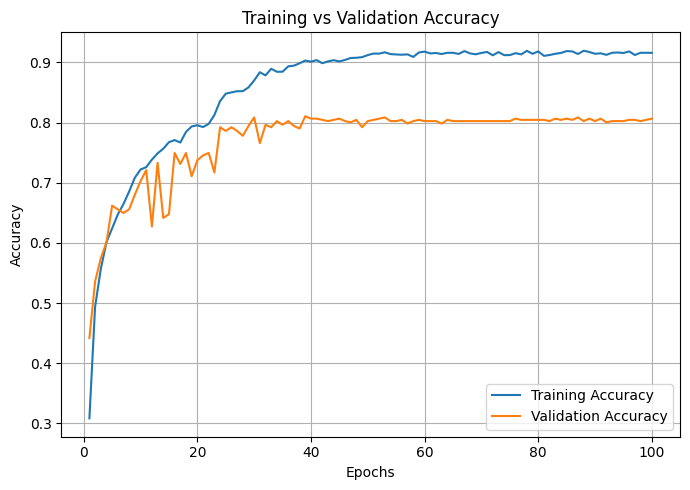

In [18]:
import matplotlib.pyplot as plt

# Extract accuracy values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step
              precision    recall  f1-score   support

       angry       0.94      0.89      0.92        75
        calm       0.83      0.89      0.86        75
     disgust       0.82      0.84      0.83        38
     fearful       0.76      0.71      0.73        75
       happy       0.79      0.71      0.75        76
     neutral       0.79      0.89      0.84        38
         sad       0.71      0.79      0.75        76
   surprised       0.85      0.76      0.81        38

    accuracy                           0.81       491
   macro avg       0.81      0.81      0.81       491
weighted avg       0.81      0.81      0.81       491



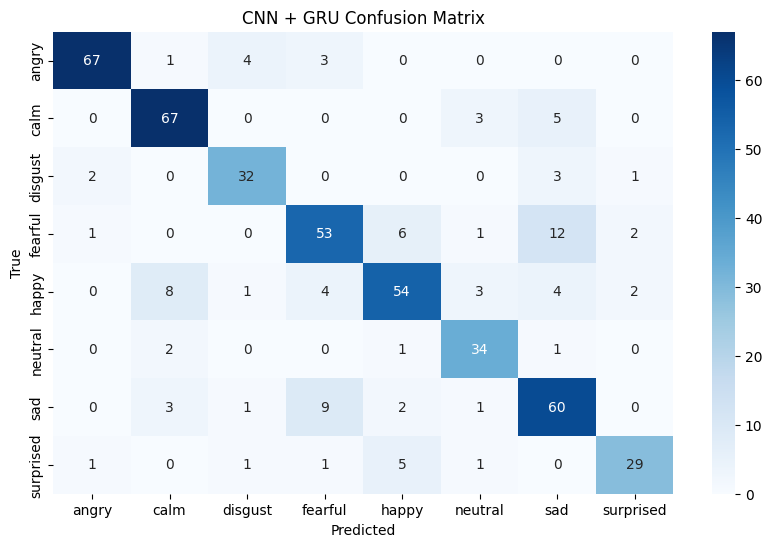

In [19]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
y_pred = model.predict(X_test_pad)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_cat, axis=1)

# Report
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CNN + GRU Confusion Matrix")
plt.show()

In [20]:
model.save('/content/drive/MyDrive/best_model.h5')